#### Exploring Grad-CAM
Blog post [link](https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353)

In [1]:
!pip install pickle5

In [2]:
# import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, losses, optimizers, callbacks, Model

import os
import time
import numpy as np
import pandas as pd

import helpers as helper
from keras_model_s3_wrapper import *

import boto3
import pickle5 as pickle
s3 = boto3.resource('s3')
bucket_name = 'wafer-capstone'
my_bucket = s3.Bucket(bucket_name)

In [3]:
tf.__version__

'2.3.4'

In [4]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [5]:
tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
# specify variables
path = 'processed_data/WM-clean-paper'
result_path = 'results'

filename = 'WM-clean-paper'
map_column = 'waferMap224'

model_id = 'yutandem'
data_id = 'paper'
note = '' # -optional

detect_model = 'yudetect-paper'
classify_model = 'yuclassify-paper'

In [7]:
# load test set(s) to be used
# directly from S3 (using boto3 resource)
start = time.time()

test_key = f'{path}/{filename}-test.pkl'
test = pickle.loads(my_bucket.Object(test_key).get()['Body'].read())

print("Wall time: {:.2f} seconds".format(time.time() - start))
print(f"Test: {len(test)}")

Wall time: 26.58 seconds
Test: 25943


In [8]:
# load saved classify model from S3
start = time.time()

classify = s3_get_keras_model(classify_model)
classify.summary()

print("Wall time: {:.2f} seconds".format(time.time() - start))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 1)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 224, 224, 1)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 224, 224, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 74, 74, 64)        1

In [9]:
import cv2

def GradCam(model, img_array, layer_name, eps=1e-8):
    '''
    Creates a grad-cam heatmap given a model and a layer name contained with that model
    

    Args:
      model: tf model
      img_array: (img_width x img_width) numpy array
      layer_name: str


    Returns 
      uint8 numpy array with shape (img_height, img_width)

    '''

    gradModel = Model(inputs=[model.inputs],
                      outputs=[model.get_layer(layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        # cast the image tensor to a float-32 data type, pass the
        # image through the gradient model, and grab the loss
        # associated with the specific class index
        inputs = tf.cast(img_array, tf.float32)
        (convOutputs, predictions) = gradModel(inputs)
        loss = predictions[:, 0]
    
    # use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    
    # the convolution and guided gradients have a batch dimension
    # (which we don't need) so let's grab the volume itself and
    # discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    
    # compute the average of the gradient values, and using them
    # as weights, compute the ponderation of the filters with
    # respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
  
    # grab the spatial dimensions of the input image and resize
    # the output class activation map to match the input image
    # dimensions
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))

    # normalize the heatmap such that all values lie in the range
    # [0, 1], scale the resulting values to the range [0, 255],
    # and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    
    # heatmap = (heatmap * 255).astype("uint8")
    # return the resulting heatmap to the calling function
    return heatmap


def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def superimpose(img_bgr, cam, thresh, emphasize=False):
    
    '''
    Superimposes a grad-cam heatmap onto an image for model interpretation and visualization.
    

    Args:
      image: (img_width x img_height x 3) numpy array
      grad-cam heatmap: (img_width x img_width) numpy array
      threshold: float
      emphasize: boolean

    Returns 
      uint8 numpy array with shape (img_height, img_width, 3)

    '''
    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, thresh, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = 0.7
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img_rgb

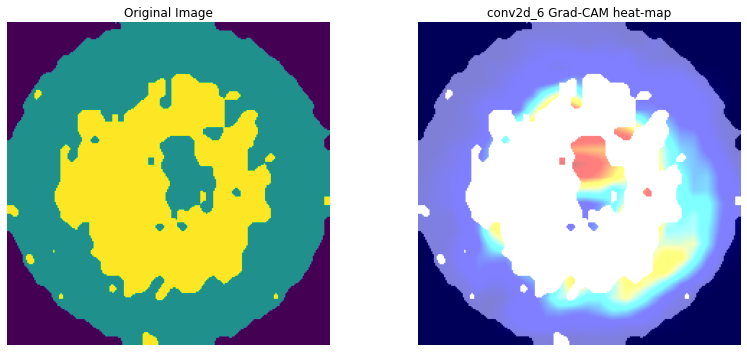

In [28]:
img = test.waferMap224[1001]

## Grad-CAM heatmap for the last convolutional layer in the model
layer_name = 'conv2d_6'
grad_cam=GradCam(classify, np.expand_dims(img, axis=0), layer_name)

img2 = np.uint8(img/2*255)
img_bgr = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
# # sanity check - expect (224, 224, 3)
# img_bgr.shape

grad_cam_superimposed = superimpose(img_bgr, grad_cam, 0.5, emphasize=False)

plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title(f'{layer_name} Grad-CAM heat-map')
plt.tight_layout()

In [29]:
def superimpose2(img_bgr, cam, thresh, emphasize=False):
    
    '''
    Superimposes a grad-cam heatmap onto an image for model interpretation and visualization.
    

    Args:
      image: (img_width x img_height x 3) numpy array
      grad-cam heatmap: (img_width x img_width) numpy array
      threshold: float
      emphasize: boolean

    Returns 
      uint8 numpy array with shape (img_height, img_width, 3)

    '''
    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, thresh, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    superimposed_img_rgb = cv2.addWeighted(img_bgr, 0.7, heatmap, 0.8, 0)
    
#     hif = 0.8
#     superimposed_img = heatmap * hif + img_bgr
#     superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
#     superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img_rgb

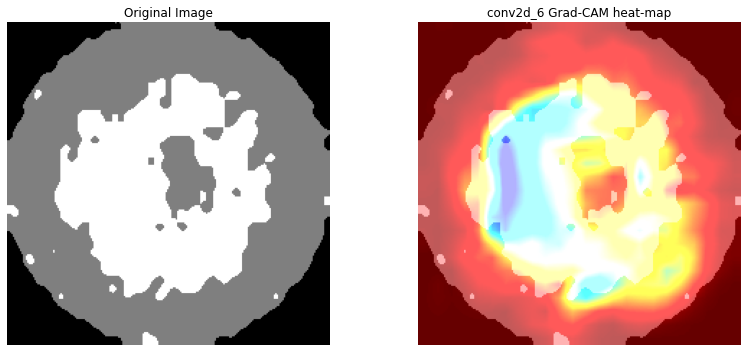

In [33]:
img = test.waferMap224[1001]

## Grad-CAM heatmap for the last convolutional layer in the model
layer_name = 'conv2d_6'
grad_cam=GradCam(classify, np.expand_dims(img, axis=0), layer_name)

img2 = np.uint8(img/2*255)
img_bgr = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
# # sanity check - expect (224, 224, 3)
# img_bgr.shape

grad_cam_superimposed2 = superimpose2(img_bgr, grad_cam, 0.5, emphasize=False)

plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(img_bgr)
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed2)
plt.axis('off')
plt.title(f'{layer_name} Grad-CAM heat-map')
plt.tight_layout()

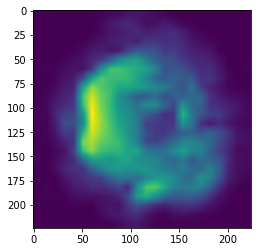

In [34]:
plt.imshow(grad_cam)

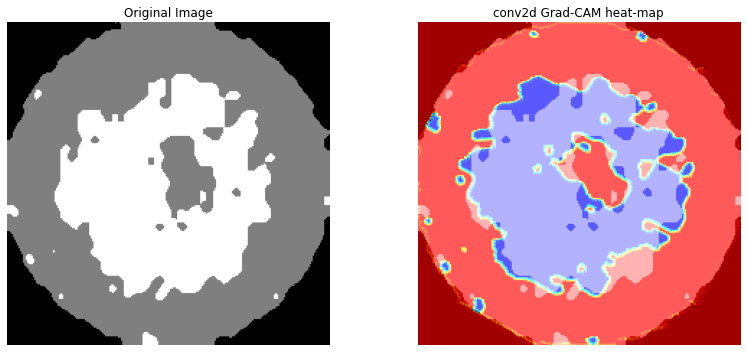

In [35]:
layer_name = 'conv2d'
grad_cam=GradCam(classify, np.expand_dims(img, axis=0), layer_name)

grad_cam_superimposed2 = superimpose2(img_bgr, grad_cam, 0.5, emphasize=False)

plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(img_bgr)
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed2)
plt.axis('off')
plt.title(f'{layer_name} Grad-CAM heat-map')
plt.tight_layout()

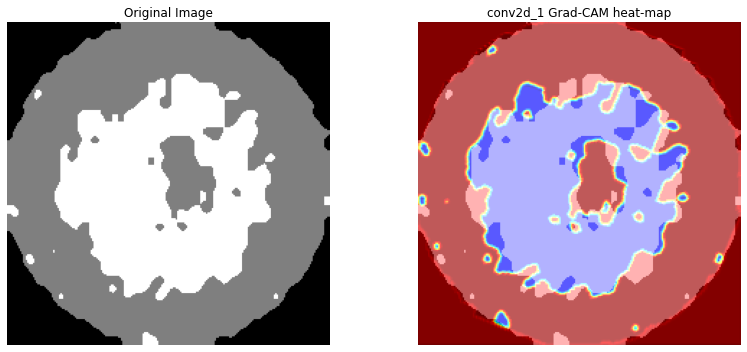

In [36]:
layer_name = 'conv2d_1'
grad_cam=GradCam(classify, np.expand_dims(img, axis=0), layer_name)

grad_cam_superimposed2 = superimpose2(img_bgr, grad_cam, 0.5, emphasize=False)

plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(img_bgr)
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed2)
plt.axis('off')
plt.title(f'{layer_name} Grad-CAM heat-map')
plt.tight_layout()

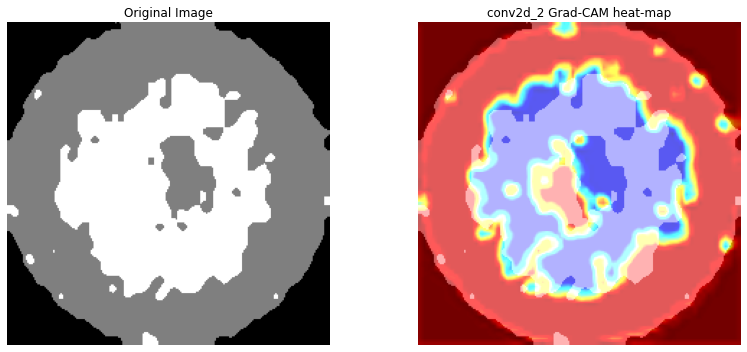

In [37]:
layer_name = 'conv2d_2'
grad_cam=GradCam(classify, np.expand_dims(img, axis=0), layer_name)

grad_cam_superimposed2 = superimpose2(img_bgr, grad_cam, 0.5, emphasize=False)

plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(img_bgr)
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed2)
plt.axis('off')
plt.title(f'{layer_name} Grad-CAM heat-map')
plt.tight_layout()

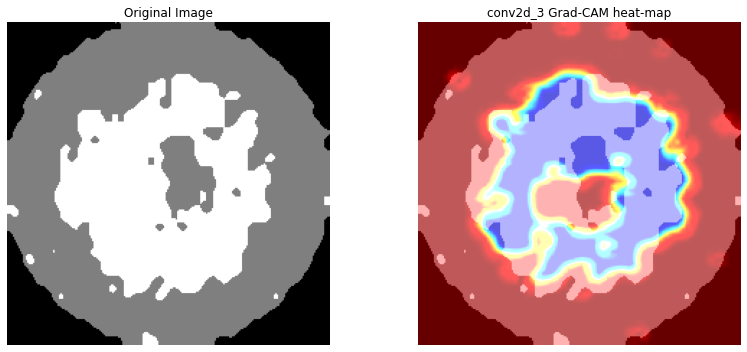

In [38]:
layer_name = 'conv2d_3'
grad_cam=GradCam(classify, np.expand_dims(img, axis=0), layer_name)

grad_cam_superimposed2 = superimpose2(img_bgr, grad_cam, 0.5, emphasize=False)

plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(img_bgr)
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed2)
plt.axis('off')
plt.title(f'{layer_name} Grad-CAM heat-map')
plt.tight_layout()

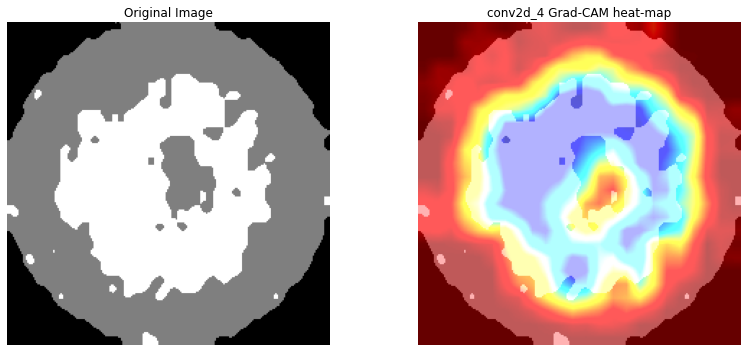

In [39]:
layer_name = 'conv2d_4'
grad_cam=GradCam(classify, np.expand_dims(img, axis=0), layer_name)

grad_cam_superimposed2 = superimpose2(img_bgr, grad_cam, 0.5, emphasize=False)

plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(img_bgr)
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed2)
plt.axis('off')
plt.title(f'{layer_name} Grad-CAM heat-map')
plt.tight_layout()

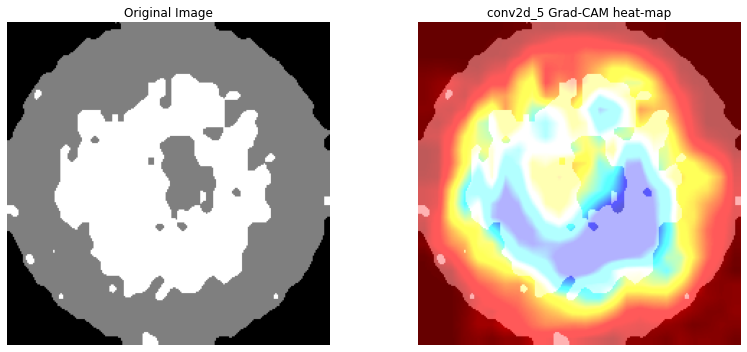

In [40]:
layer_name = 'conv2d_5'
grad_cam=GradCam(classify, np.expand_dims(img, axis=0), layer_name)

grad_cam_superimposed2 = superimpose2(img_bgr, grad_cam, 0.5, emphasize=False)

plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(img_bgr)
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed2)
plt.axis('off')
plt.title(f'{layer_name} Grad-CAM heat-map')
plt.tight_layout()

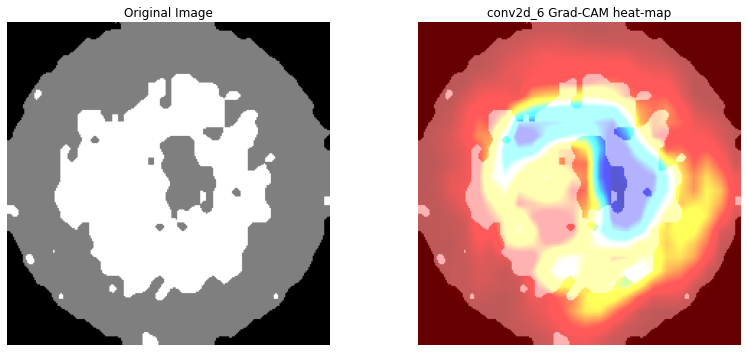

In [41]:
layer_name = 'conv2d_6'
grad_cam=GradCam(classify, np.expand_dims(img, axis=0), layer_name)

grad_cam_superimposed2 = superimpose2(img_bgr, grad_cam, 0.5, emphasize=False)

plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(img_bgr)
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed2)
plt.axis('off')
plt.title(f'{layer_name} Grad-CAM heat-map')
plt.tight_layout()

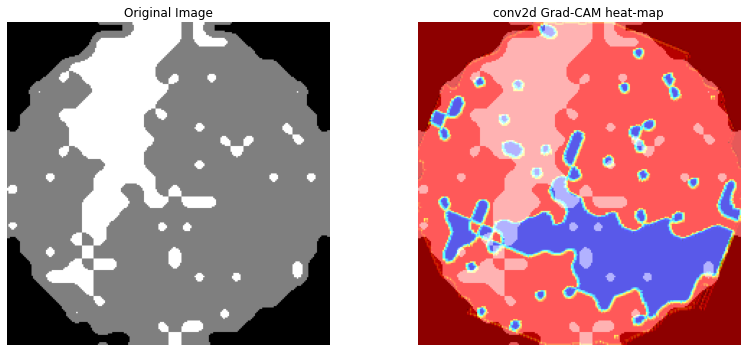

In [47]:
img = test.waferMap224[238]

## Grad-CAM heatmap for the last convolutional layer in the model
layer_name = 'conv2d'
grad_cam=GradCam(classify, np.expand_dims(img, axis=0), layer_name)

img2 = np.uint8(img/2*255)
img_bgr = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
# # sanity check - expect (224, 224, 3)
# img_bgr.shape

grad_cam_superimposed2 = superimpose2(img_bgr, grad_cam, 0.5, emphasize=False)

plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(img_bgr)
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed2)
plt.axis('off')
plt.title(f'{layer_name} Grad-CAM heat-map')
plt.tight_layout()

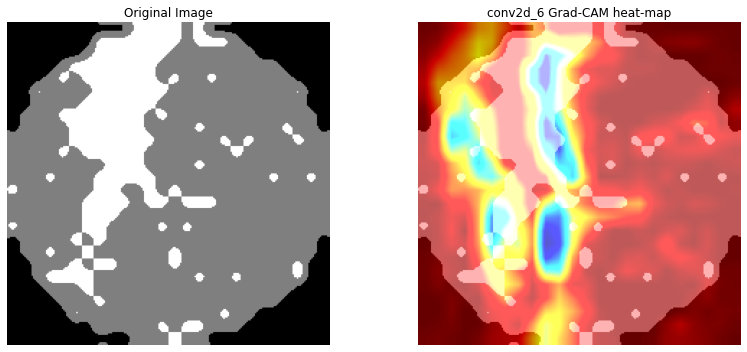

In [49]:
img = test.waferMap224[238]

## Grad-CAM heatmap for the last convolutional layer in the model
layer_name = 'conv2d_6'
grad_cam=GradCam(classify, np.expand_dims(img, axis=0), layer_name)

img2 = np.uint8(img/2*255)
img_bgr = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
# # sanity check - expect (224, 224, 3)
# img_bgr.shape

grad_cam_superimposed2 = superimpose2(img_bgr, grad_cam, 0.5, emphasize=False)

plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(img_bgr)
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed2)
plt.axis('off')
plt.title(f'{layer_name} Grad-CAM heat-map')
plt.tight_layout()